In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

import sys
helios_source = '../../HELIOS/source'
if helios_source not in sys.path:
    sys.path.append(helios_source)
from species_database import species_lib

cmap = plt.get_cmap('viridis')
plt.rcParams['figure.dpi'] = 200

In [2]:
folder = "../output/EqCond+Remove/"
#folder = "../output/test_newCIAs/"
name = "Earth_P0=1e7_Tint=100_CplusO=1e-2_CtoO=0.59_aN=1e-4" # add "_NoCond" between Tint and CplusO for EqChem folder
path = f"{folder}{name}/" + "Static_Conc_{var}.dat"

# Load data
i = 0
step = 1

dimension = np.genfromtxt(path.format(var=i), dtype=int,  max_rows=1, skip_header=1)
print(dimension)
n_elem = dimension[0]
n_mol = dimension[1]
n_dust = dimension[2]
n_layers = dimension[3]

header = np.loadtxt(path.format(var=i), skiprows=2, max_rows=1, dtype=str)
atom_names = header[3:4+n_elem]
mol_names = header[4+n_elem:4+n_elem+n_mol]
dust_names = header[4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
dust_names = np.array([dust_name[1:] for dust_name in dust_names]) # Remove first character (S)

inds = []
PTs = []
nHtots = []
data = []
atoms = []
mols = []
supersats = []
dusts = []
mus = []
eps_atoms = []
dust_to_gas = []
convective = []

print(path[:-21])

while True:
    with warnings.catch_warnings():
        warnings.simplefilter("error", UserWarning)
        try:
            d = np.loadtxt(path.format(var=i), skiprows=3)
            data.append(d)

            PTs.append(np.array([d[:,2]*1e-6, d[:,0]]).T) # convert pressure from dyn/cm^2 to bar
            nHtots.append(d[:,1])
            atoms.append(d[:,3:4+n_elem])
            mols.append(d[:,4+n_elem:4+n_elem+n_mol])
            supersats.append(d[:,4+n_elem+n_mol:4+n_elem+n_mol+n_dust])
            dusts.append(d[:,4+n_elem+n_mol+n_dust:4+n_elem+n_mol+2*n_dust])
            eps_atoms.append(d[:, 4+n_elem+n_mol+2*n_dust:4+n_elem+n_mol+2*n_dust+n_elem])
            dust_to_gas.append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem])

            inds.append(i)

            mu = path[:-21] + f'vertical_mix_{i}.dat'
            mu = np.loadtxt(mu, skiprows=1, usecols=3)
            mus.append(mu)

            conv = folder + name + f'/{name}_tp.dat'
            conv = np.loadtxt(conv, skiprows=2, usecols=6)
            convective.append(conv)
            
            i += step
        except (FileNotFoundError, UserWarning):
            break

converted = False

i_rcbs = []
for i in range(len(convective)):
    i_rcb = int(np.sum(convective[i]))
    i_rcbs.append(i_rcb)

[ 4 52  7 85]
../output/EqCond+Remove/Earth_P0=1e7_Tint=100_CplusO=1e-2_CtoO=0.59_aN=1e-4/


In [3]:
print(len(header))
print(len(data))
print(data[0].shape)

print(header[3:4+n_elem])

if not converted:
    n_tots = []
    for i in range(len(data)):
        n_tot = 10**data[i][:, 3:4+n_elem+n_mol]
        n_tot = np.sum(n_tot, axis=1)
        n_tots.append(n_tot[:,None])

    # convert atomic abundances (log(cm^-3)) to volume mixing ratios
    for i, atom in enumerate(atoms):
        atom = 10**atom
        atoms[i] = atom / n_tots[i]
    
    # convert molecular abundances (log(cm^-3)) to volume mixing ratios
    for i, mol in enumerate(mols):
        mol = 10**mol
        mols[i] = mol / n_tots[i]

    #for i in range(len(supersats)):
    #    supersats[i] = 10**supersats[i]

    # convert concentrations of condensates from log10(nCond/nHtot) to volume mixing ratios
    for i in range(len(dusts)):
        dusts[i] = 10**(dusts[i]) * nHtots[i][:,None] / n_tots[i]
    
    converted = True


82
12
(85, 82)
['el' 'H' 'C' 'O' 'N']


In [4]:
def set_white(ax):
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.tick_params(axis='x', colors='white', which='both')  # Set color for both major and minor ticks
    ax.tick_params(axis='y', colors='white', which='both')  # Set color for both major and minor ticks

def increase_size(ax, linewidth=3, fontsize=14, legendcols=1, legendloc='best'):
    for l in ax.lines:
        l.set_linewidth(linewidth)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(linewidth)
    ax.xaxis.set_tick_params(width=linewidth)
    ax.yaxis.set_tick_params(width=linewidth)
    fontsize = 14
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.legend(fontsize=fontsize, ncols=legendcols, loc=legendloc)
    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 11
461.285
334.347
320.971
312.992
308.321
305.602
304.031
303.128
302.61
302.314
302.314
0.17301959831672248


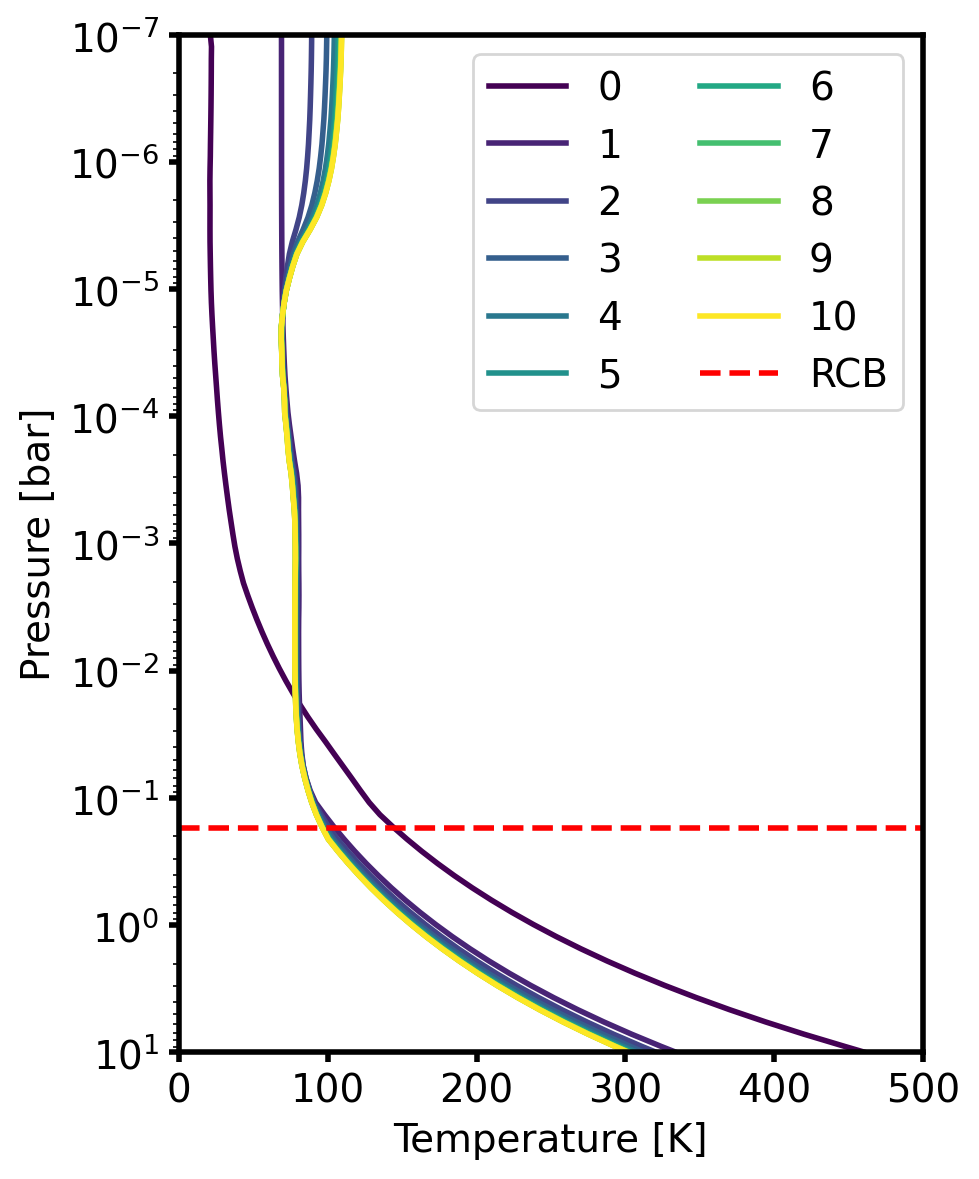

In [7]:
plot_diff = False

if plot_diff:
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(10, 5))
else:
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 6))

start = 1
step = 1
stop = len(PTs)
print(inds)
sel_inds = inds[start:stop:step]
print(inds, sel_inds[-1])

for i, pt in enumerate(PTs[start:stop:step]):
    print(pt[0,1])
    ax1.plot(pt[:,1], pt[:,0], label=f"{sel_inds[i]-1}", color=cmap(i*step/np.maximum((stop-start-1),1)))

ax1.legend(ncols=2)
ax1.invert_yaxis()
ax1.set_yscale("log")
#ax1.set_xscale("log")
ax1.set_xlim(0, 500)
ax1.set_ylim(PTs[0][0,0], PTs[0][-1,0]*1e0)
#ax1.set_xticks(np.arange(500, 3500, 100), minor=True)
#ax1.set_xticks(np.arange(800, 3201, 400))

ax1.set_xlabel("Temperature [K]")
ax1.set_ylabel("Pressure [bar]")
ax1.set_title(name.replace("_", ", ").replace("plus", "+").replace("to", "/"))
#ax1.grid()

if plot_diff:
    # Plot differences in the slimmer column
    for i, pt in enumerate(PTs[start:stop:step]):
        compare = PTs[sel_inds[-1]]
        diff = pt[:compare.shape[0],1]-compare[:,1]
        ax2.plot(diff, pt[:compare.shape[0],0], label=f"{sel_inds[i]}-{sel_inds[-1]}", color=cmap(i*step/np.maximum((stop-start-1),1)))

    ax2.invert_yaxis()
    ax2.set_xscale("symlog", linthresh=1e0)
    ax2.set_yscale("log")
    ax2.set_xlim(-100, 100)
    ax2.set_ylim(PTs[0][0,0], PTs[0][-1,0]*1e0)
    ax2.set_xlabel(r"$\Delta$T [K]")
    ax2.set_title("Difference\nto last iteration", fontsize=10)
    ax2.grid()

plt.tight_layout()

P_rcb = 10**((np.log10(PTs[0][i_rcbs[-1],0]) + np.log10(PTs[0][i_rcbs[-1]-1,0]))/2)
print(P_rcb)

# plot rcb
ax1.hlines(P_rcb, 0, 500, color='red', linestyle='--', linewidth=2, label='RCB')

if True:
    #set_white(ax1)
    increase_size(ax1, linewidth=2, fontsize=10, legendcols=2)
    ax1.set_title("")
    plt.tight_layout()
    plt.savefig(f"images/Paper1/TPevolution_{name}.svg", format="svg", transparent=True)

plt.show()

Surface abundance of H2: 0.9881265547627739


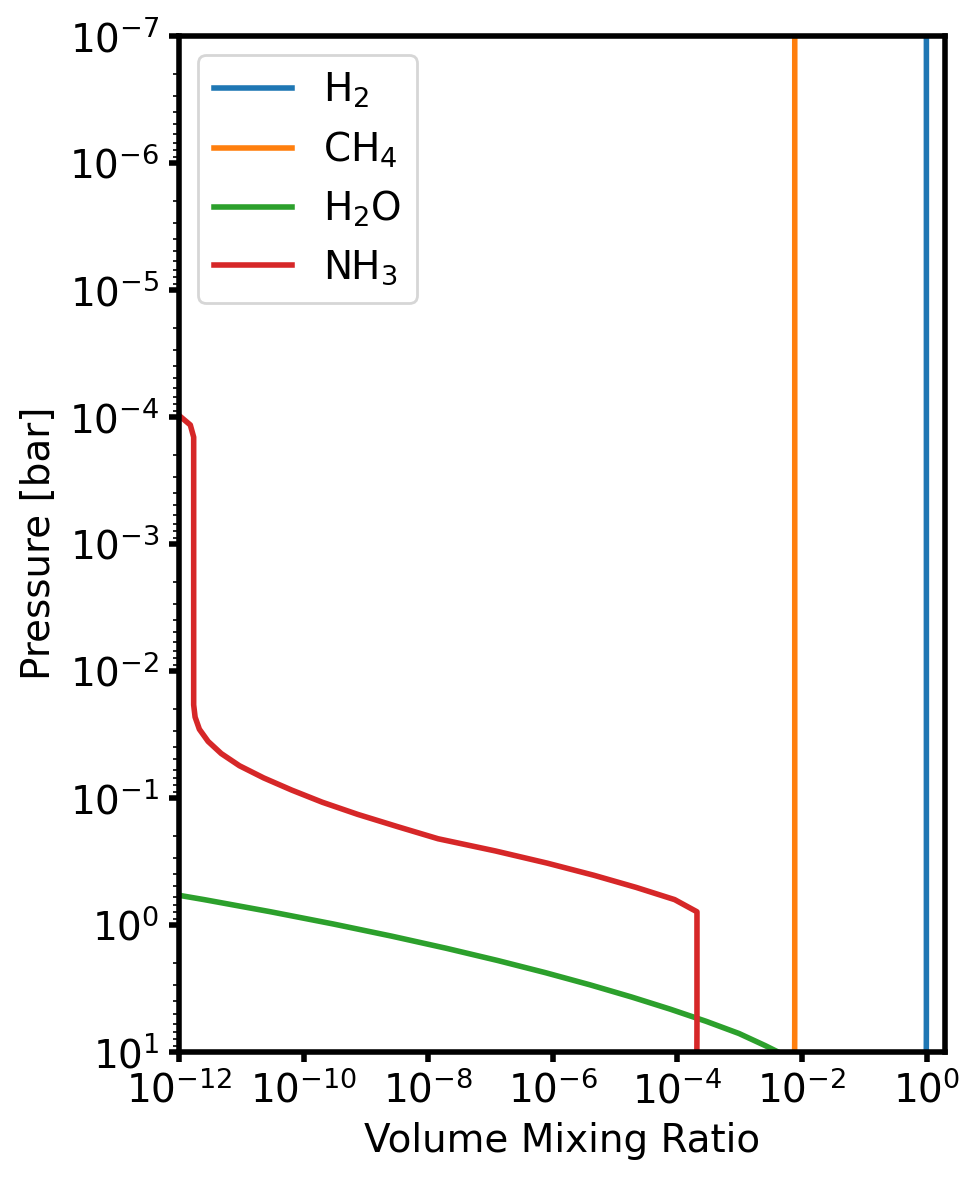

In [8]:
# plot mixing ratios for certain step
i = len(mols)-1
plot_mass_mr = False

threshold = 1e-12

if threshold is not None:
    mask = mols[i] > threshold
    mask = np.any(mask, axis=0)
else:
    target_molecules = ['H2', 'H2O', 'CO2', 'CO', 'CH4', 'C2H2', 'C2H4']
    mask = np.isin(mol_names, target_molecules)
    #sort = np.argsort(mols[i][:,mask].max(axis=0))[::-1]

labels = mol_names[mask]
# insert '_ before integers and insert $ for subscripts
for j, label in enumerate(labels):
    for number in np.arange(10, dtype=int):
        labels[j] = labels[j].replace(f"{number}", "$_{" + f"{number}" + "}$")

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

if plot_mass_mr:
    try:
        masses = [species_lib[name].weight for name in mol_names[mask]]
    except:
        raise KeyError("Error calculating mass: molecule name not found.")

    ax1.plot(mols[i][:,mask]*masses/mus[i][:,None], PTs[i][:,0], label=labels)
else:
    surface_abund = mols[i][0,mask]
    print(f'Surface abundance of {mol_names[mask][surface_abund.argmax()]}: {surface_abund.max()}')
    ax1.plot(mols[i][:,mask], PTs[i][:,0], label=labels)

xlog = True
if xlog:
    ax1.set_xscale('log')
    ax1.set_xlim(threshold, 2e0)
else:
    ax1.set_xlim(0, 1.05)

ax1.set_yscale('log')
ax1.set_ylim(PTs[0][0,0], PTs[0][-1,0]*1e0)

if plot_mass_mr:
    ax1.set_xlabel('Mass Mixing Ratio')
else:
    ax1.set_xlabel('Volume Mixing Ratio')
ax1.set_ylabel('Pressure [bar]')
#ax1.title(f'Mass mixing ratios for step {i}')
#ax1.title(name.replace("_", ", ") + f' (step {i})')

ax1.legend(loc='upper left')

if True:
    # change figsize
    plt.title("")
    plt.gcf().set_size_inches(5, 6)
    #set_white(ax1)
    increase_size(ax1, legendloc='upper left', linewidth=2, fontsize=10)
    plt.tight_layout()
    plt.savefig(f"images/Paper1/MixingRatios_{name}_step{i}.svg", format="svg", transparent=True)

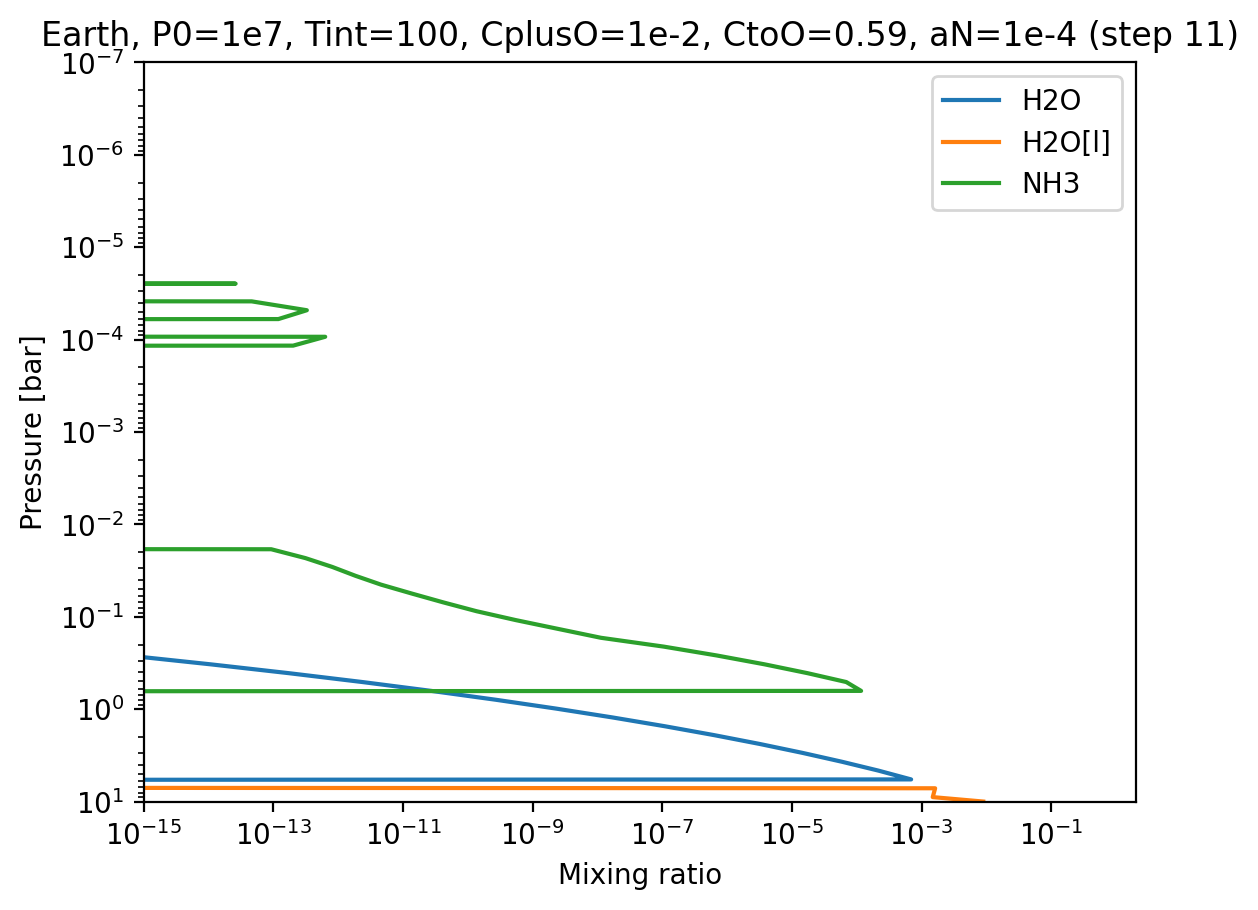

In [40]:
# plot the dust "mixing ratios"
i = len(mols)-1

threshold = 1e-12

if threshold is not None:
    mask = dusts[i] > threshold
    mask = np.any(mask, axis=0)
else:
    target_molecules = dust_names #['H2', 'H2O', 'H2O[l]', 'CO2', 'CO', 'CH4', 'NH3']
    mask = np.isin(dust_names, target_molecules)
    #sort = np.argsort(mols[i][:,mask].max(axis=0))[::-1]

#print(supersats[i][:,mask])
plt.plot(dusts[i][:,mask], PTs[i][:,0], label=dust_names[mask])
plt.vlines(0, PTs[i][0,0], PTs[i][-1,0], linestyle='dashed', color='black')

plt.xscale('log')
plt.xlim(1e-15, 2e0)

plt.yscale('log')
plt.ylim(PTs[0][0,0], PTs[0][-1,0]*1e0)

if plot_mass_mr:
    plt.xlabel('Mass mixing ratio')
else:
    plt.xlabel('Mixing ratio')
plt.ylabel('Pressure [bar]')
#plt.title(f'Mass mixing ratios for step {i}')
plt.title(name.replace("_", ", ") + f' (step {i})')

plt.legend()

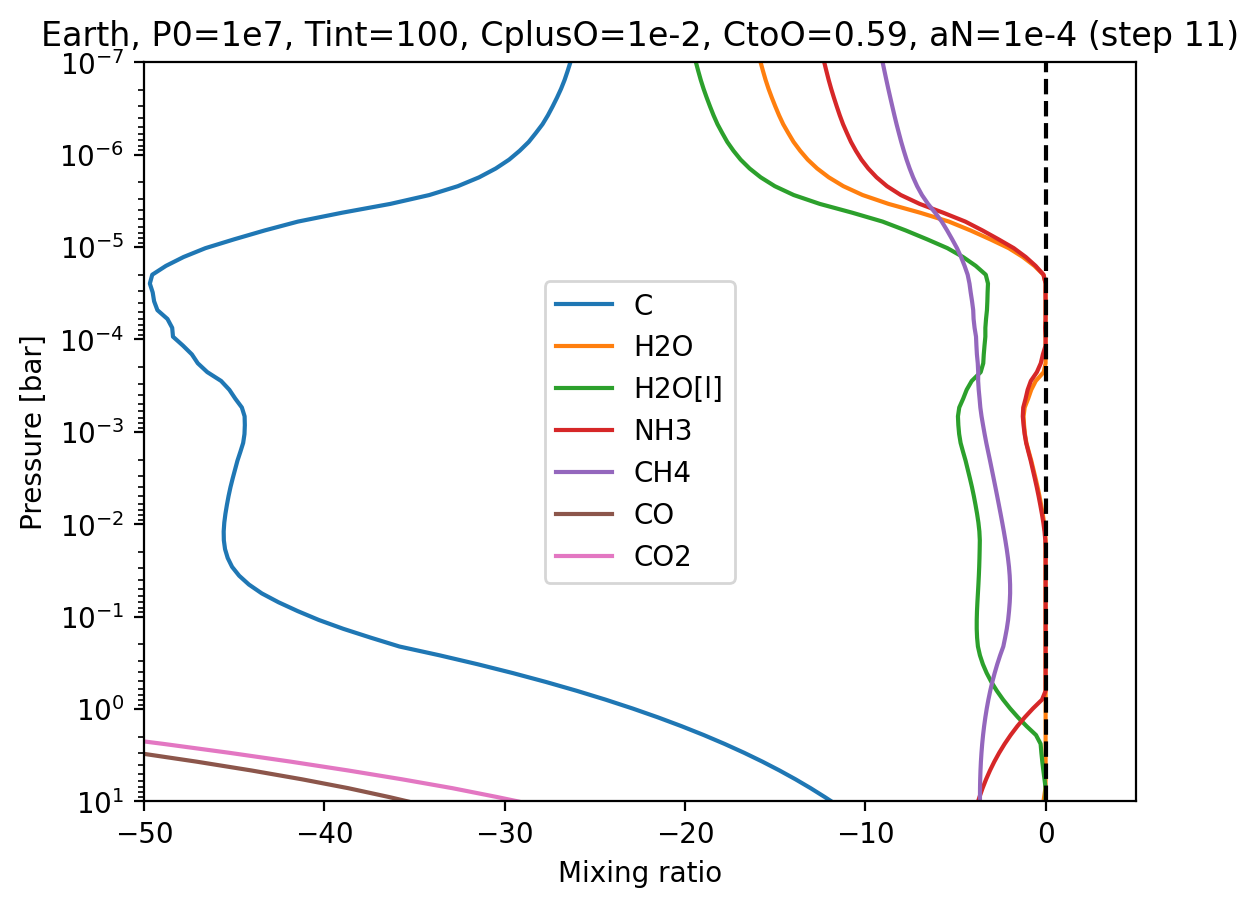

In [41]:
# plot abundances of dust species
i = len(mols)-1

threshold = None

if threshold is not None:
    mask = mols[i] > threshold
    mask = np.any(mask, axis=0)
else:
    target_molecules = dust_names #['H2', 'H2O', 'H2O[l]', 'CO2', 'CO', 'CH4', 'NH3']
    mask = np.isin(dust_names, target_molecules)
    #sort = np.argsort(mols[i][:,mask].max(axis=0))[::-1]

#print(supersats[i][:,mask])
plt.plot(supersats[i][:,mask], PTs[i][:,0], label=dust_names[mask])
plt.vlines(0, PTs[i][0,0], PTs[i][-1,0], linestyle='dashed', color='black')

plt.xlim(-50, 5)

plt.yscale('log')
plt.ylim(PTs[0][0,0], PTs[0][-1,0]*1e0)

if plot_mass_mr:
    plt.xlabel('Mass mixing ratio')
else:
    plt.xlabel('Mixing ratio')
plt.ylabel('Pressure [bar]')
#plt.title(f'Mass mixing ratios for step {i}')
plt.title(name.replace("_", ", ") + f' (step {i})')

plt.legend()

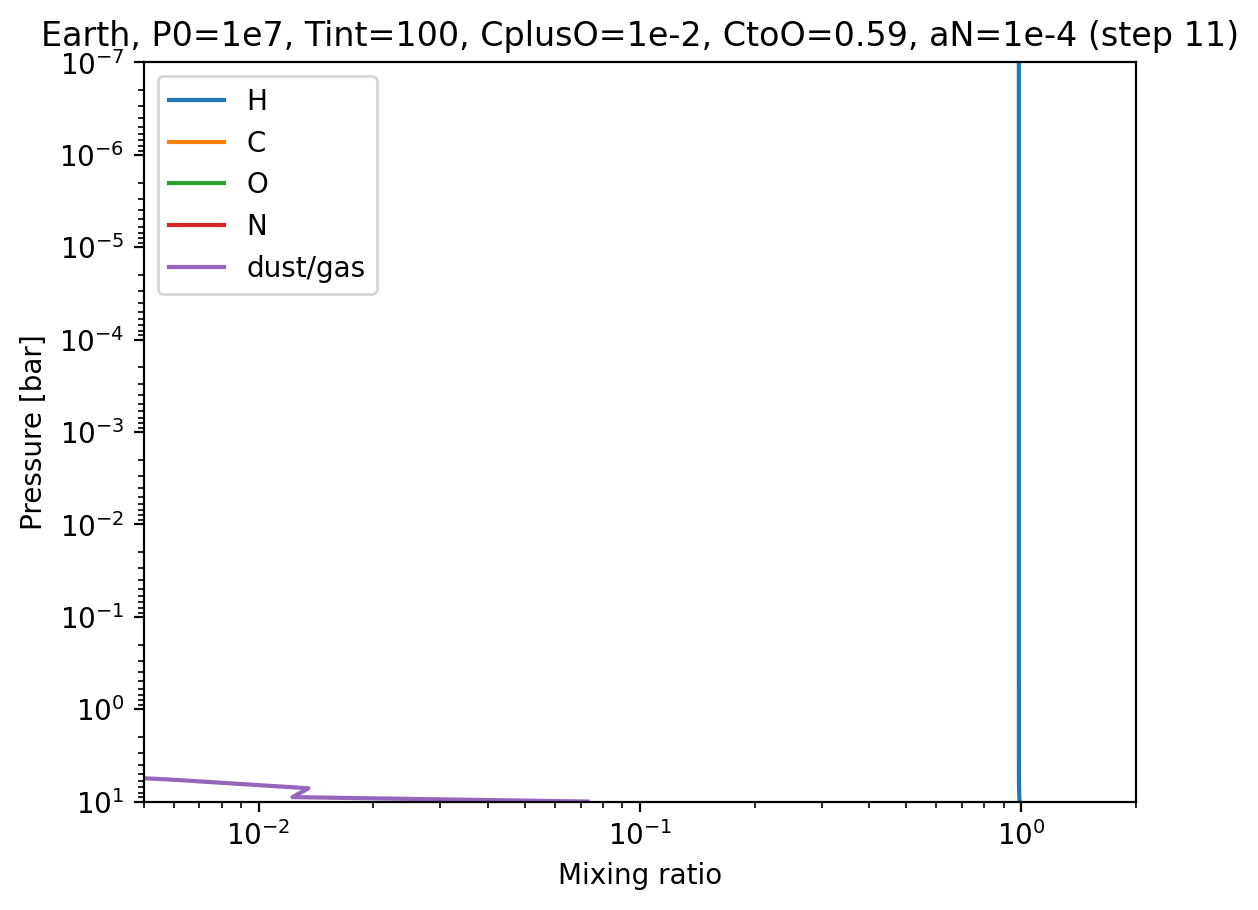

In [42]:
# plot eps_atoms
i = len(mols)-1

#print(atom_names[1:], 10**eps_atoms[i][-1,:])
plt.plot(10**eps_atoms[i], PTs[i][:,0], label=atom_names[1:])
plt.plot(10**dust_to_gas[i], PTs[i][:,0], label='dust/gas')
#plt.plot(mus[i], PTs[i][:,0], label=r'$\mu$')

xlog = True
if xlog:
    plt.xscale('log')
    plt.xlim(5e-3, 2e0)
else:
    #plt.xlim(0, 1.05)
    plt.xlim()

plt.yscale('log')
plt.ylim(PTs[0][0,0], PTs[0][-1,0]*1e0)

if plot_mass_mr:
    plt.xlabel('Mass mixing ratio')
else:
    plt.xlabel('Mixing ratio')
plt.ylabel('Pressure [bar]')
#plt.title(f'Mass mixing ratios for step {i}')
plt.title(name.replace("_", ", ") + f' (step {i})')

plt.legend()

In [26]:
R_Jup = 69.911e8 # cm

R_Io = 0.026056 * R_Jup

height_1dex = 1.12834e8 # cm

print(R_Io, height_1dex)
print(height_1dex/R_Io)

182160101.6 112834000.0
0.6194221402432507
